# Library Import and Environment Setting

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('seaborn')
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['legend.fontsize'] = 20

In [2]:
# basic_nodes
class plus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None
      
  def forward(self,x,y):
    self._x, self._y = x, y
    self._z = self._x + self._y
    return self._z
  
  def backward(self, dz): # dz = dJ/dz
    return dz*1,dz*1 #dJ/dx= dJ/dz * dz/dx, dJ/dy

class minus_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x, self._y = x, y
    self._z = self._x - self._y
    return self._z

  def backward(self, dz):
    return 1*dz, -1*dz

class mul_node:
  def __init__(self):
    self._x, self._y = None, None
    self._z = None

  def forward(self, x, y):
    self._x , self._y = x, y
    self._z = self._x * self._y
    return self._z

  def backward(self, dz):
    return dz*self._y, dz*self._x # dJ/dz * dz/dx, dJ/dy

class square_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = self._x * self._x
    return self._z

  def backward(self, dz):
    return dz*(2*self._x)

class mean_node:
  def __init__(self):
    self._x = None
    self._z = None

  def forward(self, x):
    self._x = x
    self._z = np.mean(self._x) # z = 1/n *(x1+x2+...+xn)
    return self._z

  def backward(self, dz):
    dx = dz*1/len(self._x)*np.ones_like(self._x) # dJ/dx1 = dJ/dz * dz/dx1 = dJ/dz * (1/n)
    return dx

### Mini-batch Preparation

In [17]:
def dataset_generator(x_dict):
  x_data = np.random.normal(x_dict['mean'], x_dict['std'], x_dict['n_sample'])
  x_data_noise = x_data + x_dict['noise_factor']*np.random.normal(0,1, x_dict['n_sample'])

  if x_dict['direction'] > 0:
    y_data = (x_data_noise > x_dict['cutoff']).astype(np.int)
  else:
    y_data = (x_data_noise < x_dict['cutoff']).astype(np.int)

  data = np.zeros(shape=(x_dict['n_sample'],1))
  data = np.hstack((data, x_data.reshape(-1,1), y_data.reshape(-1,1)))
  return data

def get_data_batch(data, batch_idx):
  global n_batch, batch_size

  if batch_idx is n_batch -1:
    batch = data[batch_idx*batch_size:]
  else:
    batch = data[batch_idx*batch_size : (batch_idx+1)*batch_size]
  return batch

# Affine Module

In [19]:
class Affine:
  def __init__(self):
    self._feature_dim = 1
    self._Th = None

    self.node_imp()
    self.random_initialization()

  def node_imp(self):
    self._node1 = mul_node()
    self._node2 = plus_node()
  
  def random_initialization(self):
    r_feature_dim = 1/self._feature_dim
    self._Th = np.random.uniform(low = -1*r_feature_dim,
                                 high = r_feature_dim,
                                 size = (self._feature_dim+1, 1))
  def forward(self, X):
    self._Z1 = self._node1.forward(self._Th[1], X)
    self._Z2 = self._node2.forward(self._Th[0], self._Z1)
    return self._Z2

  def backward(self, dZ, lr):
    dTh0, dZ1 = self._node2.backward(dZ)
    dTh1, dX = self._node1.backward(dZ1)

    self._Th[1] = self._Th[1] - lr*np.sum(dTh1)
    self._Th[0] = self._Th[0] - lr*np.sum(dTh0)

  def get_Th(self):
    return self._Th

# Sigmoid Moudle

In [5]:
class Sigmoid:
  def __init__(self):
    self._Pred = None

  def forward(self, Z):
    self._Pred = 1/(1+np.exp(-1*Z))
    return self._Pred
  
  def backward(self, dPred):
    Partial = self._Pred * (1- self._Pred)
    dZ = dPred * Partial
    return dZ

# Binary Cross Entropy Module

In [7]:
class BinaryCrossEntropy_Cost:
  def __init__(self):
    self._Y, self._Pred = None, None
    self._mean_node = mean_node()

  def forward(self, Y, Pred):
    self._Y, self._Pred = Y, Pred
    Loss = -1*(Y*np.log(self._Pred) + (1-Y)*np.log(1-self._Pred))
    J = self._mean_node.forward(Loss)

  def backward(self):
    dLoss = self._mean_node.backward(1)
    dPred = dLoss * (self._Pred - self._Y)/(self._Pred*(1-self._Pred))
    return dPred

# SVLoR Module

In [8]:
class SVLoR:
  def __init__(self):
    self._feature_dim = 1

    self._affine = Affine()
    self._sigmoid = Sigmoid()

  def forward(self, X):
    Z = self._affine.forward(X)
    Pred = self._sigmoid.forward(Z)
    return Pred

  def backward(self, dPred, lr):
    dZ = self._sigmoid.backward(dPred)
    self._affine.backward(dZ, lr)

  def get_Th(self):
    return self._affine.get_Th()

# Utility Function

In [21]:
def result_tracker():
    global iter_idx, check_freq
    global th_accum, model

    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, model.get_Th()))
        cost_list.append(J)
    iter_idx += 1


def result_visualizer():
    global th_accum, cost_list
    fig,ax = plt.subplots(2, 1, figsize = (20,5))
    fig.subplots_adjust(hspace = 0.3)
    ax[0].set_title(r'$\vec{\theta}$' + 'Update ')

    ax[0].plot(th_accum[1,:], label = r'$\theta_{1}$')
    ax[0].plot(th_accum[0,:], label = r'$\theta_{0}$')

    ax[0].legend()
    iter_ticks = np.linspace(0,th_accum.shape[1],10).astype(np.int)
    ax[0].set_xticks(iter_ticks)

    ax[1].set_title('Cost')
    ax[1].plot(cost_list)
    ax[1].set_xticks(iter_ticks)

    n_pred = 1000
    fig,ax = plt.subplots(figsize = (20,5))
    ax.set_title('Predictor Update')
    ax.scatter(data[:,1], data[:,-1])

    ax_idx_arr = np.linspace(0,len(cost_list)-1,n_pred).astype(np.int)
    cmap = cm.get_cmap('rainbow',lut = len(ax_idx_arr))

    x_pred = np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000)
    for ax_cnt, ax_idx in enumerate(ax_idx_arr):
        z = th_accum[1, ax_idx] * x_pred + th_accum[0,ax_idx]
        a = 1/(1 + np.exp(-1 * z))
        ax.plot(x_pred, a, color = cmap(ax_cnt),alpha = 0.2)

    y_ticks = np.round(np.linspace(0, 1, 7),2)
    ax.set_yticks(y_ticks)

# Learning

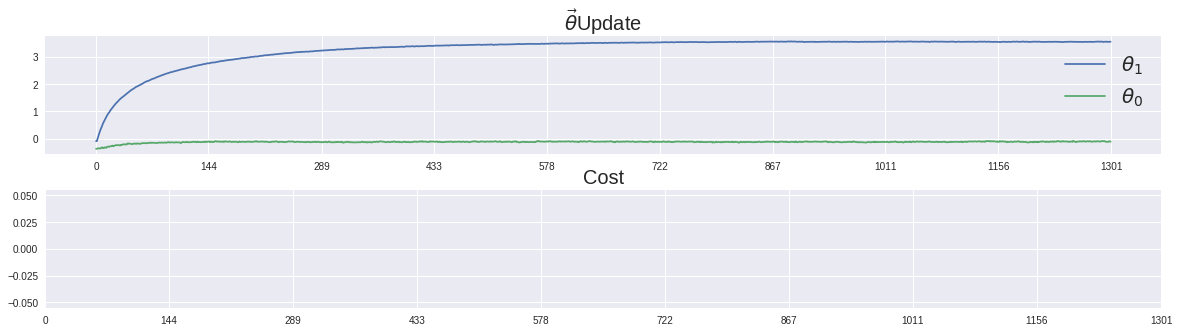

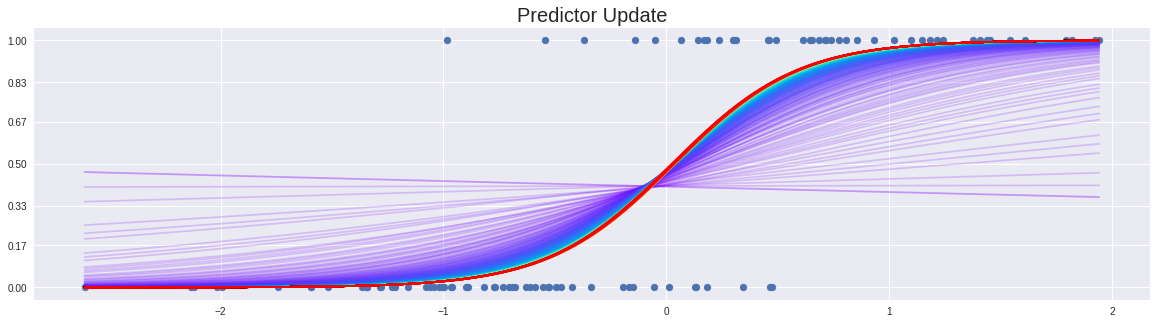

In [24]:
# 데이터 생성
x_dict =  {'mean':0, 'std':1, 'n_sample':100,
            'noise_factor':0.5,
            'cutoff':0, 'direction':1}

data = dataset_generator(x_dict)

# batch size 선언
batch_size = 8
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

# 모델 선언
model = SVLoR()
BCE_cost = BinaryCrossEntropy_Cost()

# parameter setting
th_accum = model.get_Th()
cost_list = []
epochs, lr =  500, 0.05
iter_idx, check_freq = 0, 5

# training
for epoch in range(epochs):
  np.random.shuffle(data)

  for batch_idx in range(n_batch):
    batch_data = get_data_batch(data, batch_idx)
    X, Y = batch_data[:,1], batch_data[:,-1]

    # forwardpropagation
    Pred = model.forward(X)
    J = BCE_cost.forward(Y, Pred)

    # backpropagation
    dPred = BCE_cost.backward()
    model.backward(dPred, lr)

    result_tracker()
  
result_visualizer()

batch size를 크게 할수록 부드럽게 학습한다. <br/>
Noise에 대한 Loss들도 평균적으로 반영하기 때문

# Analysis

### mean을 증가

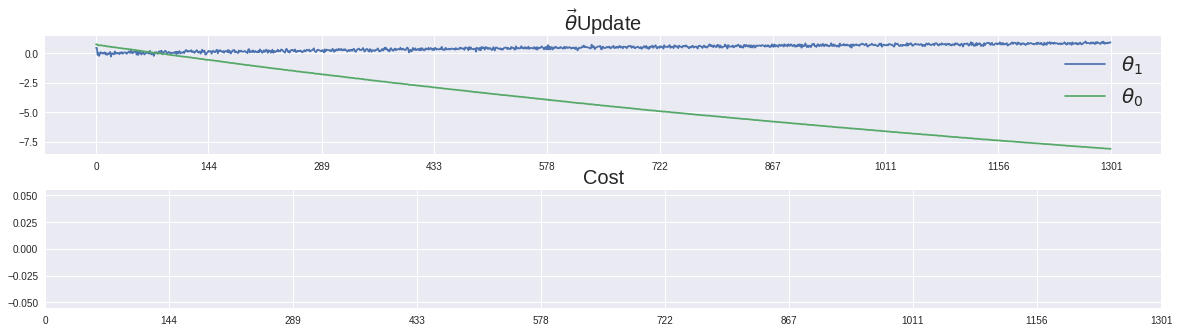

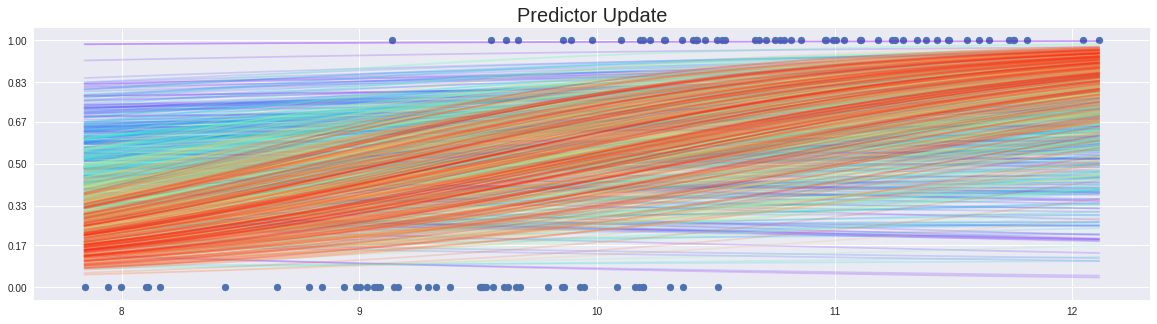

In [25]:
x_dict =  {'mean':10, 'std':1, 'n_sample':100,
            'noise_factor':0.5,
            'cutoff':10, 'direction':1}

data = dataset_generator(x_dict)

batch_size = 8
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

model =  SVLoR()
BCE_Cost = BinaryCrossEntropy_Cost()

th_accum = model.get_Th()
cost_list = []
epochs, lr =  500, 0.05
iter_idx, check_freq = 0, 5



for epoch in range(epochs):
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):
        batch = get_data_batch(data, batch_idx)
        X,Y =  batch[:,1], batch[:,-1]

        Pred = model.forward(X)
        J = BCE_Cost.forward(Y, Pred)

        dPred = BCE_Cost.backward()
        model.backward(dPred, lr)

        result_tracker()
result_visualizer()

mean의 값을 증가시켜서 학습하게 되면
x2와 x1이 불균형하게 학습

### std를 증가

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


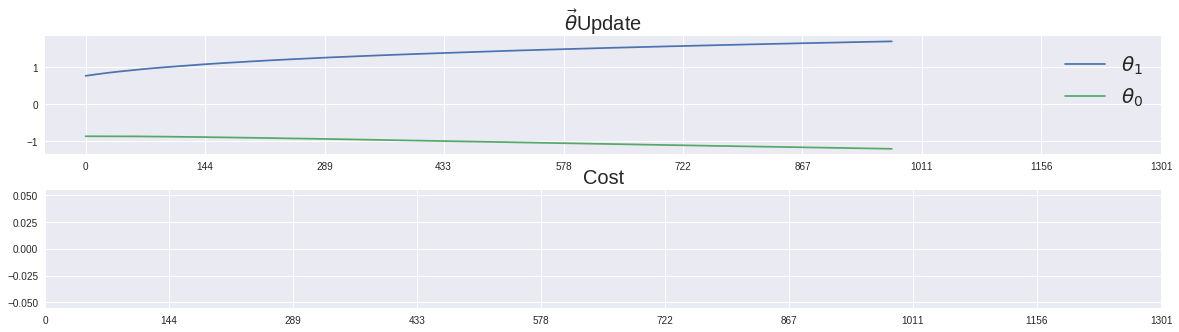

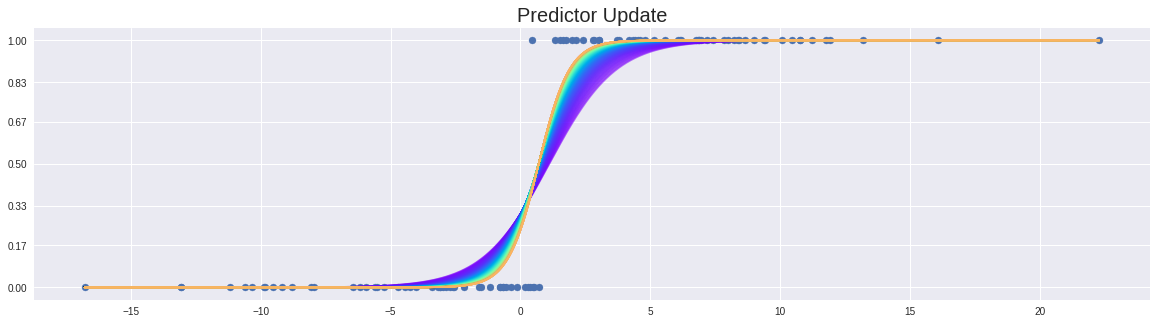

In [28]:
x_dict =  {'mean':1, 'std':7, 'n_sample':100,
            'noise_factor':0.5,
            'cutoff':1, 'direction':1}

data = dataset_generator(x_dict)

batch_size = 8
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

model =  SVLoR()
BCE_Cost = BinaryCrossEntropy_Cost()

th_accum = model.get_Th()
cost_list = []
epochs, lr =  500, 0.005
iter_idx, check_freq = 0, 5



for epoch in range(epochs):
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):
        batch = get_data_batch(data, batch_idx)
        X,Y =  batch[:,1], batch[:,-1]

        Pred = model.forward(X)
        J = BCE_Cost.forward(Y, Pred)

        dPred = BCE_Cost.backward()
        model.backward(dPred, lr)

        result_tracker()

result_visualizer()